In [1]:
# sys libs
import json
import glob
import re
import pathlib
import os
from datetime import datetime
from itertools import chain
import time
import string

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyLDAvis
import pyLDAvis.gensim_models

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel
from sklearn.manifold import TSNE

# knee locator
from kneed import KneeLocator

#spacy
import spacy
from nltk.corpus import stopwords

# mlflow
import mlflow
from mlflow.exceptions import MlflowException

# surpress warnings
import warnings
warnings.filterwarnings("ignore")

/Users/Taras_Ustyianovych/workspace/python-envs/lda-venv/lib/python3.9/site-packages/mlflow/gateway/config.py:63: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("cohere_api_key", pre=True)
/Users/Taras_Ustyianovych/workspace/python-envs/lda-venv/lib/python3.9/site-packages/mlflow/gateway/config.py:72: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("ai21labs_api_key", pre=True)
/Users/Taras_Ustyianovych/workspac

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
def remove_redundant_words(text_data):
    # Remove Emails
    text_data = [re.sub('\S*@\S*\s?', '', sent) for sent in text_data]

    # Remove new line characters
    text_data = [re.sub('\s+', ' ', sent) for sent in text_data]

    # Remove distracting single quotes
    text_data = [re.sub("\'", "", sent) for sent in text_data]

    # Remove HTTPS
    text_data = [re.sub("https|http", "", sent) for sent in text_data]
    
    return text_data


def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)


def remove_stopwords(texts, stopwords):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]


def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts, trigram_mod, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def apply_tfidf_to_corpus(corpus, id2word, low_value):
    tfidf = TfidfModel(corpus, id2word)
    words = []
    words_missing_in_tfidf = []
    new_corpus = []

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] # reinitialize to be safe. You can skip this.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        
        for item in drops:
            words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        new_corpus.append(new_bow)
    
    return new_corpus


# use if text has to be prepared for inference
def preprocess_new_data(text_data, stopwords, id2word, tfidf_low_value, min_count=5, threshold=25):
    
    text_data = remove_redundant_words(text_data)
    data_words = gen_words(text_data)
    data_words_cleaned = remove_stopwords(data_words, stopwords)
    
    # Build the bigram and trigram models
    bigram_phrases = gensim.models.Phrases(data_words_cleaned, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words_cleaned], threshold=threshold)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram_phrases)
    trigram_mod = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(data_words_cleaned, bigram_mod)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram_mod, bigram_mod)
    
    corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
    
    if len(corpus) > 1:
        new_corpus = apply_tfidf_to_corpus(corpus, id2word, tfidf_low_value)
        return new_corpus
    
    else:
        return corpus


def preprocess_input_data(text_data, stopwords, id2word, tfidf_low_value, min_count, threshold, is_training):
    
    text_data = remove_redundant_words(text_data)
    data_words = gen_words(text_data)
    data_words_cleaned = remove_stopwords(data_words, stopwords)
    
    # Build the bigram and trigram models
    bigram_phrases = gensim.models.Phrases(data_words_cleaned, min_count=5, threshold=25) # higher threshold fewer phrases.
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words_cleaned], threshold=25)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram_phrases)
    trigram_mod = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(data_words_cleaned, bigram_mod)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram_mod, bigram_mod)

    if id2word is None:
        id2word = corpora.Dictionary(data_bigrams_trigrams)

    corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
    if len(corpus) > 1:
        corpus = apply_tfidf_to_corpus(corpus, id2word, tfidf_low_value)

    
    if is_training:
        return data_bigrams_trigrams, corpus, id2word
    else:
        return corpus

In [4]:
def unique_id(prefix, size):
    chars = list(string.digits)
    generated_nums = ''.join(random.choices(chars, k=size))
    return '{0}{1}'.format(prefix, generated_nums)


def compute_lda_models_performance(experiment_name, experiment_logging_path, artifact_logging_path, dictionary, corpus, texts, limit, start=2, step=1, save_results_to_file=True):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    artifact_location = pathlib.PurePath(artifact_logging_path).as_uri()
    
    current_date = datetime.strftime(datetime.now(), "%d-%m-%Y")   
    try:
        experiment_id = mlflow.create_experiment(name=experiment_name,
                                             artifact_location=artifact_location)
    except MlflowException:
        experiment = mlflow.set_experiment(experiment_name)
        experiment_id = experiment.experiment_id

    filename = 'model-training-logs-{0}-{1}.csv'.format(current_date, experiment_id)
    experiment_logging_path = os.path.join(experiment_logging_path, filename)

    for num_topics in range(start, limit, step):
        
        with mlflow.start_run(experiment_id=experiment_id) as run:

            model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 100, chunksize = 80, eval_every=10)
            coherencemodel_u_mass = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
            coherencemodel_c_v = CoherenceModel(model=model, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_value_u_mass = coherencemodel_u_mass.get_coherence()
            coherence_value_c_v = coherencemodel_c_v.get_coherence()
            perplexity_value = model.log_perplexity(corpus)

            print("Finished computing for topic #%d" % (num_topics))

            
            mlflow.log_metric('perplexity', perplexity_value)
            mlflow.log_metric('coherence_value_u_mass', coherence_value_u_mass)
            mlflow.log_metric('coherence_value_c_v', coherence_value_c_v)
            
            mlflow.log_param('num_topics', num_topics)
            mlflow.log_param('corpus_length', len(corpus))
            mlflow.log_param('experiment_name', experiment_name)
            
            
    runs = mlflow.search_runs(experiment_names=[experiment_name])
    
    if save_results_to_file:
        runs.to_csv(experiment_logging_path, index=False)
        
    return runs

In [5]:
def get_topics_from_predictions(prob_distribution):
    max_prob = 0
    max_prob_topic = 0
    for i in prob_distribution:
        if i[1] > max_prob:
            max_prob = i[1]
            max_prob_topic = i[0]
    return [max_prob_topic, max_prob]


def predict(lda_model, corpus, topn=None):
    predictions = []

    if topn:
        for item in corpus:
            prob_distribution = lda_model.get_document_topics(item, minimum_probability=0.0)
            results = sorted(prob_distribution, key = lambda sub: (-sub[1], sub[0]))[:topn]
            predictions.append(results)
    else:
        for item in corpus:
            prob_distribution = lda_model.get_document_topics(item, minimum_probability=0.0)
            result = get_topics_from_predictions(prob_distribution)
            predictions.append(result)
    
    return predictions

In [6]:
def get_mean_topic_vectors(keys, two_dim_vectors, n_topics):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        topic_centroid_results = dict()
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        
        topic_centroid_results['predicted_topic'] = t
        topic_centroid_results['x_centroid'] = mean_article_in_that_topic[0]
        topic_centroid_results['y_centroid'] = mean_article_in_that_topic[1]
        
        mean_topic_vectors.append(topic_centroid_results)
        
    return mean_topic_vectors


def compute_tsne(train_vectors, n_components=2):
    np_train_vecs = np.array(train_vectors)
    
    tsne_lda_model = TSNE(n_components=n_components, perplexity=50, learning_rate=2.5,
                        n_iter=3000, verbose=1, random_state=0, angle=0.7, init='pca')
    tsne_lda_vectors = tsne_lda_model.fit_transform(np_train_vecs)
    
    return tsne_lda_vectors


def get_tsne_distance(x_centroid, y_centroid, x, y):
        distances = np.sqrt((x-x_centroid)**2+(y-y_centroid)**2)
        return distances

In [7]:
nlp_ru = spacy.load("ru_core_news_lg")

In [37]:
RU_STOPWORDS_CUSTOM = pd.read_csv('ru-stopwords.txt', header=None)
RU_STOPWORDS_CUSTOM = list(RU_STOPWORDS_CUSTOM[0].unique())

EXTRA_STOPWORDS = ['Article', 'article', 'http', 
                    'https', 'youtube', 'youtu',
                  'www', 'news', 'index', 'amp',
                  'com', 'rus', 'ua', 'ru', 'ссылка']

ru_stopwords = nlp_ru.Defaults.stop_words

for extra_stopword in EXTRA_STOPWORDS:
    ru_stopwords.add(extra_stopword)

for stopword in RU_STOPWORDS_CUSTOM:
    ru_stopwords.add(stopword)

In [9]:
def clean_raw_text(docs):
    
    docs = remove_redundant_words(docs)
    docs_processed = []
    
    for doc in docs:
        doc_preprocessed = "".join((char if char.isalpha() else " ") for char in doc.rstrip())
        doc_processed = " ".join(doc_preprocessed.split())
        
        docs_processed.append(doc_processed)
    
    return docs_processed


def token_filter(token, stopwords):
    return not (token.is_punct | token.is_space | token.is_stop | len(token.text) <= 2 | (token in stopwords))


def spacy_parallel_doc_processing(nlp, stopwords, docs):
        
    filtered_tokens = []

    for index, doc in enumerate(nlp.pipe(docs)):

        tokens = [token.lemma_ for token in doc if token_filter(token, stopwords)]
        tokens_filtered = [token for token in tokens if token not in stopwords]
        doc_result = ' '.join(tokens_filtered)
        
        filtered_tokens.append(doc_result)
       
    return filtered_tokens


def spacy_doc_processing(docs):
    filtered_tokens = []

    for doc in docs:

        nlp_doc = nlp_ru(doc)
        tokens = [token.lemma_ for token in nlp_doc if token_filter(token, ru_stopwords)]
        tokens_filtered = [token for token in tokens if token not in ru_stopwords]
        doc_result = ' '.join(tokens_filtered)
    
        filtered_tokens.append(doc_result)

       
    return filtered_tokens


def preprocess_text(docs, parallel):

    cleaned_docs = clean_raw_text(docs)
    
    
    if parallel:
        lemmatized_processed_docs = spacy_parallel_doc_processing(nlp_ru, ru_stopwords, cleaned_docs)
    else:
        lemmatized_processed_docs = spacy_doc_processing(cleaned_docs)
    
    return lemmatized_processed_docs

In [10]:
def find_optimal_topic_numbers(lda_model_training_runs, priority_metric):
    # sort the df by number of topics in ascending order
    lda_model_training_runs = lda_model_training_runs.sort_values(by='params.num_topics', ascending=True)
    
    # set the x-axis values
    x = lda_model_training_runs['params.num_topics'].astype(int).values

    # set the y-axis values for all three metrics
    y1 = lda_model_training_runs['metrics.perplexity'].astype(float).values
    y2 = lda_model_training_runs['metrics.coherence_value_u_mass'].astype(float).values
    y3 = lda_model_training_runs['metrics.coherence_value_c_v'].astype(float).values

    elbows = {}
    optimal_elbows = {}

    
    for i, (y, name) in enumerate([(y1, 'metrics.perplexity'), (y2, 'metrics.coherence_value_u_mass'), (y3, 'metrics.coherence_value_c_v')]):

        # calculate first and second derivatives
        

        # Compute the first and second order differences of the coherence values
        delta1 = pd.Series(y).diff()    # Compute the first order difference of values
        delta2 = delta1.diff()
        
        elbow = -1
        found_elbows = []
        optimal_indexes = []

        # find verticies
        if name == 'metrics.coherence_value_c_v':
            delta1_indexes = delta1.sort_values(ascending=False).index
            for delta1_index in delta1_indexes:
                if delta1_index == max(delta1_indexes):
                    elbow = x[delta1_index]
                    found_elbows.append(elbow)
                    
                elif delta1[delta1_index] > 0 and y[delta1_index+1] < y[delta1_index]:
                    elbow = x[delta1_index]
                    
                    found_elbows.append(elbow)
                    optimal_indexes.append(delta1_index)
            
            elbow = [x[index] for index in optimal_indexes if y[index] == max(y[optimal_indexes])][0]

        # find elbows 
        elif name == 'metrics.perplexity':
            knee = KneeLocator(x, y, curve='concave', direction='decreasing', online=True, interp_method='interp1d')
            found_elbows_perplexity = list(knee.all_elbows_y)
            found_elbows = list(knee.all_elbows)
            elbow = found_elbows[np.argmin(found_elbows_perplexity)]

        # find top values closest to zero
        elif name == 'metrics.coherence_value_u_mass':
            y2_abs = np.abs(y2)
            found_elbow_index = np.argmin(y2_abs)
            found_elbows_indexes = list(np.argsort(y2_abs)[:3])

            elbow = x[found_elbow_index]
            found_elbows = list(x[found_elbows_indexes])
            
        else:
            print("No such metric name found")
            
        # if no elbow point was found, choose the number of topics with the maximum CV coherence value
        if elbow == -1 and name != 'metrics.perplexity':
            elbow = x[y.argmax()]
            found_elbows.append(elbow)

        # add elbow point to dictionary
        elbows[name] = found_elbows
        optimal_elbows[name] = elbow
    
        
    # take the best topic number based on coherence CV score
    print("found optimal elbows: ", elbows)
    print("selected optimal elbows: ", optimal_elbows)
    print("number of topics based on metrics.coherence_value_c_v is selected")
    best_topic_num = optimal_elbows[priority_metric]

    return elbows

#### Load training data

In [9]:
data = pd.read_csv('../data/tg-data-sample-preprocessed-labeled.csv', 
                   encoding='utf-16')

In [10]:
data.shape

(10000, 7)

In [7]:
data.head()

,Channel Name,Date,Message ID,Message,message_processed_lemmatized,label,label_encoded
72906,rian_ru,2023-05-15 11:38:58+00:00,202783,Минобрнауки и Роспотребнадзор рекомендовали ву...,минобрнауки роспотребнадзор рекомендовать вуз ...,pro-ru,0
15043,radiosvoboda,2023-05-15 07:06:02+00:00,40861,Президенты Франции и Украины Эммануэль Макрон ...,президент франция украина эммануэль макрон вла...,pro-ua,1
161670,UkrPravdaMainNews,2023-07-21 11:25:46+00:00,62879,Гиркина-Стрелкова задержали в России по наводк...,гиркин стрелкова задержать наводка бывший вагн...,pro-ua,1
138630,uniannet,2023-07-17 17:07:28+00:00,105224,"Ответ со стороны россии конечно будет, Минобор...",ответ минобороны готовить соответствующий пред...,pro-ua,1
135682,uniannet,2023-06-07 18:41:01+00:00,100925,Некоторые жители Херсона отказываются эвакуиро...,житель херсон отказываться эвакуироваться зато...,pro-ua,1


In [17]:
main_data = data.sample(frac = 0.9)
unseen_data = data.drop(main_data.index)

In [38]:
input_text_data = main_data['Message'].to_list()
print(len(input_text_data))

preprocessed_text_data = preprocess_text(input_text_data, parallel = True)

print(len(preprocessed_text_data))

data_bigrams_trigrams, corpus, id2word_dict = preprocess_input_data(text_data = preprocessed_text_data, stopwords = ru_stopwords,
                                                                    id2word = None, tfidf_low_value = 0.05, min_count = 5,
                                                                    threshold = 25 , is_training=True)

data_bigrams_trigrams = [item for item in data_bigrams_trigrams if len(item)>0]
print("Data processing done")

5000
5000
Data processing done


In [26]:
input_text_data[:5]

['Дрон зафиксировал выход защитников Мариуполя с "Азовстали"',
 'Уровень одобрения деятельности президента России Владимира Путина среди опрошенных "Левада-центром" в сентябре упал по сравнению с предыдущим месяцем на 6 процентов. \n\nВ августе деятельность Путина одобряли 83 процента опрошенных, в сентябре - 77. Опрос был проведён уже после того, как президент объявил в России мобилизацию.\n\nДо российского вторжения в Украину рейтинг Путина по опросам "Левады" составлял около 70 процентов, а после начала войны вырос до уровня более 80 процентов, на котором оставался до недавнего времени.\n\nВ открытом вопросе, когда респондентам предлагали самим назвать имена политиков, которым они доверяют, рейтинг Путина упал с 44 до 40 процентов.\n\n"Левада-центр" отмечает, что упал уровень доверия и к другим представителям властей, а также уменьшилось число людей, считающих, что дела в стране идут в правильном направлении - в августе таких было 67 процентов, после объявления мобилизации - на 7 пр

In [27]:
preprocessed_text_data[:5]

['дрон зафиксировать выход защитник мариуполь азовстали',
 'уровень одобрение деятельность президент владимир путин опросить левада центр сентябрь упасть сравнение предыдущий месяц август деятельность путин одобрять процент опросить сентябрь опрос провести президент объявить мобилизация российский вторжение украина рейтинг путин опрос левада составлять процент начало вырасти уровень процент оставаться недавний открытый респондент предлагать назвать политик доверять рейтинг путин упасть процент левада центр отмечать упасть уровень доверие представитель власть уменьшиться число правильный направление август процент объявление мобилизация Об отношение мобилизация опрос проводиться опубликовать четверг результат традиционный ежемесячный опрос украина следовать сентябрь россиянин пристальный следить беспокоиться связь событие украина число беспокоить достигнуть процент показатель начало процент опросить показатель заявить поддерживать действие российский военный украина число сторонник мирн

In [31]:
data_bigrams_trigrams[:5]

[['дрон', 'зафиксировать', 'выход', 'защитник', 'мариуполь', 'азовстали'],
 ['уровень',
  'одобрение',
  'деятельность',
  'президент_владимир_путин',
  'опросить',
  'левада',
  'центр',
  'сентябрь',
  'упасть',
  'сравнение',
  'предыдущии',
  'месяц',
  'август',
  'деятельность',
  'путин',
  'одобрять',
  'процент',
  'опросить',
  'сентябрь',
  'опрос',
  'провести',
  'президент',
  'объявить',
  'мобилизация',
  'россиискии',
  'вторжение_украина',
  'реитинг',
  'путин',
  'опрос',
  'левада',
  'составлять',
  'процент',
  'начало',
  'вырасти',
  'уровень',
  'процент',
  'оставаться',
  'недавнии',
  'открытыи',
  'респондент',
  'предлагать',
  'назвать',
  'политик',
  'доверять',
  'реитинг',
  'путин',
  'упасть',
  'процент',
  'левада',
  'центр',
  'отмечать',
  'упасть',
  'уровень',
  'доверие',
  'представитель',
  'власть',
  'уменьшиться',
  'число',
  'правильныи',
  'направление',
  'август',
  'процент',
  'объявление',
  'мобилизация',
  'отношение',
  'моб

In [28]:
corpus[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 3),
  (7, 1),
  (8, 1),
  (9, 1),
  (12, 1),
  (13, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (21, 1),
  (22, 3),
  (24, 1),
  (25, 3),
  (28, 2),
  (29, 1),
  (30, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 4),
  (36, 3),
  (38, 1),
  (39, 1),
  (40, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (50, 1),
  (52, 1),
  (53, 1),
  (55, 1),
  (56, 1),
  (57, 8),
  (58, 3),
  (60, 2),
  (61, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 3),
  (76, 3),
  (77, 2),
  (78, 1),
  (79, 4)],
 [(5, 1), (80, 1), (81, 1)],
 [(58, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1),
  (92, 1),
  (93, 1),
  (94, 1),
  (95, 1),
  (96, 1),
  (97, 1),
  (98, 1),
  (99, 1),
  (100, 1),
  (101, 1),
  (102, 1),
  (103, 1),
  (104, 1),
  (105, 1),
  (106, 1),
  (

In [21]:
CURRENT_WORK_DIR = os.getcwd()

EXPERIMENT_NAME = 'LDA-TG-SAMPLE-DATA-EXPERIMENT'
EXPERIMENT_LOGGING_PATH = os.path.join(CURRENT_WORK_DIR, 'experiments')
ARTIFACT_LOGGING_PATH = os.path.join(CURRENT_WORK_DIR, 'artifacts')


lda_model_training_runs = compute_lda_models_performance(EXPERIMENT_NAME, EXPERIMENT_LOGGING_PATH, ARTIFACT_LOGGING_PATH,
                                                    id2word_dict, corpus, data_bigrams_trigrams, limit=20, 
                                                         start=2, step=1, save_results_to_file=True)

In [15]:
# mlflow.search_experiments(filter_string=f"name = '{EXPERIMENT_NAME}'")
# mlflow.delete_experiment('129553460286219568')

In [66]:
lda_model_training_runs = lda_model_training_runs[lda_model_training_runs['params.num_topics'].notna()]

In [67]:
lda_model_training_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.perplexity,metrics.coherence_value_u_mass,metrics.coherence_value_c_v,params.corpus_length,params.num_topics,params.experiment_name,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type
0,e3a5601266864e5d99ceef852035e01a,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:34:33.391000+00:00,2023-11-11 17:34:41.752000+00:00,-11.577370,-5.861256,0.327033,5000,19,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,nervous-yak-569,Taras_Ustyianovych,LOCAL
1,3ff7d8cec646434380c40753d0bc1e91,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:34:24.636000+00:00,2023-11-11 17:34:33.390000+00:00,-11.565167,-5.636111,0.307520,5000,18,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,rebellious-eel-798,Taras_Ustyianovych,LOCAL
2,43444efd248b40a09a12d2a039974717,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:34:16.089000+00:00,2023-11-11 17:34:24.635000+00:00,-11.223146,-4.916750,0.314912,5000,17,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,bittersweet-bear-911,Taras_Ustyianovych,LOCAL
3,1d68fe4638df484280f32b07dc3fbb76,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:34:08.053000+00:00,2023-11-11 17:34:16.088000+00:00,-11.141889,-4.819618,0.324435,5000,16,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,amazing-ray-264,Taras_Ustyianovych,LOCAL
4,456062daf0b846da819021748b88bca4,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:34:00.137000+00:00,2023-11-11 17:34:08.052000+00:00,-11.041260,-4.760080,0.313548,5000,15,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,calm-ram-307,Taras_Ustyianovych,LOCAL
5,baa7fad0949c407dbd8f69e87e322433,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:33:52.478000+00:00,2023-11-11 17:34:00.136000+00:00,-11.121186,-7.091295,0.360095,5000,14,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,shivering-sheep-36,Taras_Ustyianovych,LOCAL
6,bedf454fd24e4dbdbc5023f2d6b740e8,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:33:44.457000+00:00,2023-11-11 17:33:52.477000+00:00,-10.775475,-4.527286,0.344038,5000,13,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,bright-kit-786,Taras_Ustyianovych,LOCAL
7,41a83e8c01a741dfa731870bc446abc9,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:33:36.380000+00:00,2023-11-11 17:33:44.456000+00:00,-10.740817,-4.067441,0.306789,5000,12,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,brawny-newt-720,Taras_Ustyianovych,LOCAL
8,7b1b7481784f481ea4b4b14ddd27cab2,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:33:28.584000+00:00,2023-11-11 17:33:36.378000+00:00,-10.811809,-4.349744,0.324392,5000,11,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,delicate-donkey-182,Taras_Ustyianovych,LOCAL
9,5cb6c008cf914061ba80b720093c966f,683134591859640175,FINISHED,file:///Users/Taras_Ustyianovych/workspace/my_...,2023-11-11 17:33:20.845000+00:00,2023-11-11 17:33:28.582000+00:00,-10.245839,-3.760620,0.333460,5000,10,LDA-TG-DATA-EXPERIMENT,/Users/Taras_Ustyianovych/workspace/python-env...,clumsy-seal-882,Taras_Ustyianovych,LOCAL


In [78]:
determined_elbows = find_optimal_topic_numbers(lda_model_training_runs, 'metrics.coherence_value_c_v')

found optimal elbows:  {'metrics.perplexity': [9, 13, 6, 17], 'metrics.coherence_value_u_mass': [5, 4, 3], 'metrics.coherence_value_c_v': [2, 14, 16, 7, 9, 5]}
selected optimal elbows:  {'metrics.perplexity': 6, 'metrics.coherence_value_u_mass': 5, 'metrics.coherence_value_c_v': 2}
number of topics based on metrics.coherence_value_c_v is selected


In [79]:
determined_elbows

{'metrics.perplexity': [9, 13, 6, 17],
 'metrics.coherence_value_u_mass': [5, 4, 3],
 'metrics.coherence_value_c_v': [2, 14, 16, 7, 9, 5]}

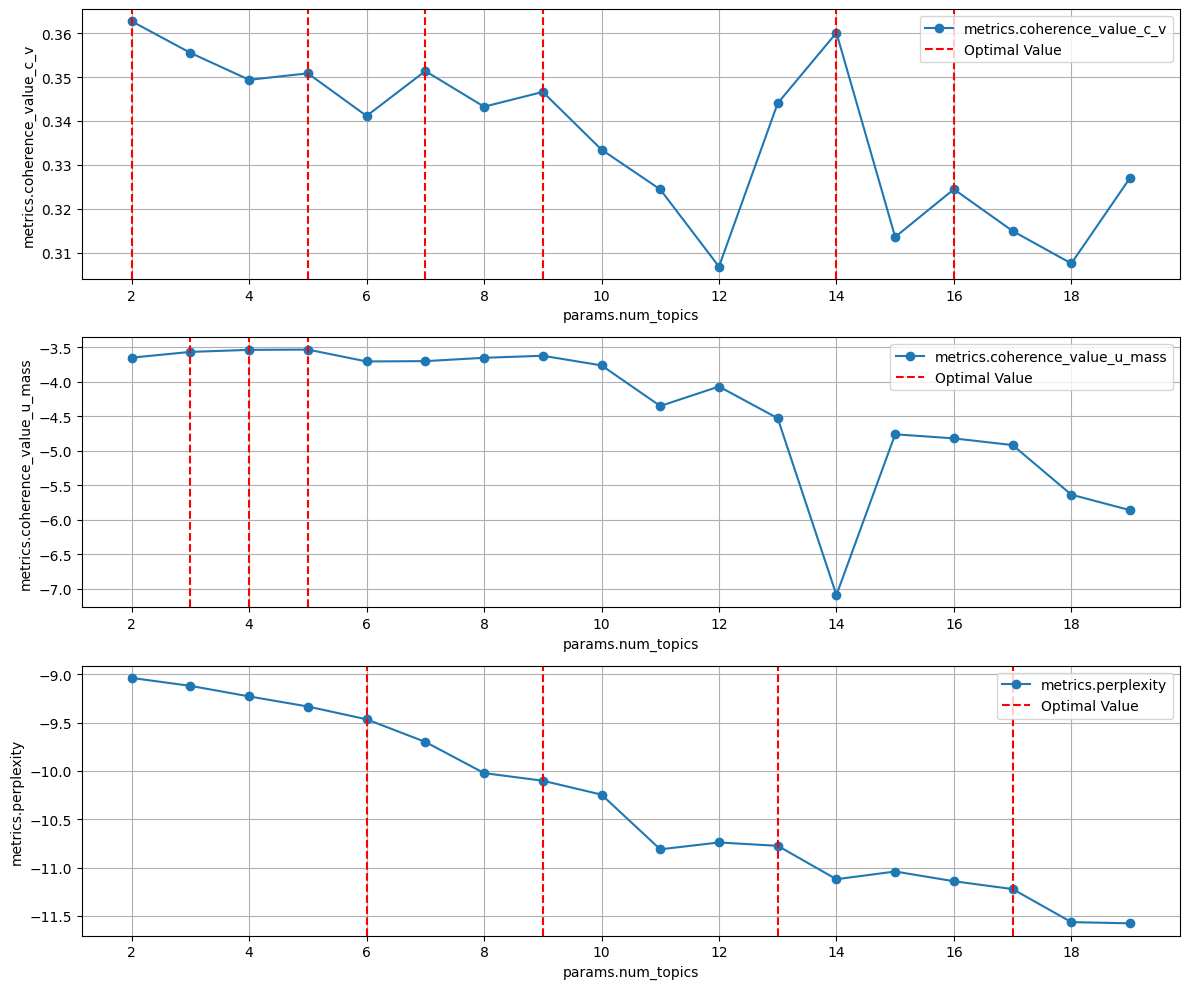

In [85]:
# visualize the results

# Define column names
metrics = ['metrics.coherence_value_c_v', 'metrics.coherence_value_u_mass', 'metrics.perplexity']

# Create a single figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
fig_indices = [
    [0, 0],
    [0, 1],
    [1, 0]
]

# Plot each metric in a separate subplot
for metric_index, metric in enumerate(metrics):
    axs[metric_index].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    axs[metric_index].plot(lda_model_training_runs['params.num_topics'].astype(int), lda_model_training_runs[metric], marker='o', label=metric)
    ymin, ymax = axs[metric_index].get_ylim()

    # Vertical line for optimal value
    local_optimal_values = determined_elbows[metric]
    axs[metric_index].vlines(x=local_optimal_values, ymin=ymin, ymax=ymax, color='r', linestyle='--', label='Optimal Value')

    axs[metric_index].set_xlabel('params.num_topics')
    axs[metric_index].set_ylabel(f'{metric}')
    axs[metric_index].legend()
    axs[metric_index].set_ylim(ymin, ymax)
    axs[metric_index].grid(True)
    

plt.tight_layout()

In [86]:
# train LDA model with the most optimal topic number
model = gensim.models.LdaMulticore(corpus=corpus, num_topics=<TOPIC NUM>, id2word=id2word_dict,
                                   random_state = 100, chunksize = 80, eval_every=10, passes=100, iterations=100)

In [94]:
MODEL_STORAGE_PATH = os.path.join(CURRENT_WORK_DIR, 'models/lda-model')


try: 
    os.makedirs(MODEL_STORAGE_PATH) 
except OSError as error: 
    print(error)  

model.save(os.path.join(MODEL_STORAGE_PATH, 'trained-lda-model'))
print('Model is trained and stored!')

Model is trained and stored!


In [105]:
vis = pyLDAvis.gensim_models.prepare(model, corpus, model.id2word, mds="mmds", R=30, sort_topics=False)
pyLDAvis.save_html(vis, "templates/lda-visualization-nov-23-2023.html")
print("Model visualization is saved!")

Model visualization is saved!


In [107]:
pyLDAvis.display(vis)

In [111]:
# let's make some inference
unseen_data

,Channel Name,Date,Message ID,Message,message_processed_lemmatized,label,label_encoded
119790,uniannet,2022-10-29 03:54:59+00:00,78063,🤡 Оккупанты в Севастополе пожаловались на атак...,оккупант севастополе пожаловаться атака дрон с...,pro-ua,1
233987,radiosvoboda,2022-07-26 07:43:32+00:00,25435,"""Вся жизнь в наглухо закрытом вагоне, набитом ...",наглухо закрыть вагон набить голодный измучить...,pro-ua,1
142849,uniannet,2023-09-18 12:22:00+00:00,111723,Закарпатская область возглавила сомнительный р...,закарпатский область возглавить сомнительный р...,pro-ua,1
42093,rian_ru,2022-06-15 09:56:49+00:00,167242,"❗️Итальянская Eni сообщила РИА Новости, что ""Г...",итальянский eni сообщить риа новость газпром у...,pro-ru,0
91055,uniannet,2022-03-12 13:49:07+00:00,37677,❗️Понаехавшие в Германию россияне вышли на акц...,понаехать германия россиянин акция протест при...,pro-ua,1
...,...,...,...,...,...,...,...
26158,rian_ru,2022-02-26 19:34:33+00:00,149109,Instagram заблокировал аккаунт помощника Кадыр...,instagram заблокировать аккаунт помощник кадыр...,pro-ru,0
84702,uniannet,2022-01-19 13:58:29+00:00,29414,💸 1 миллиард гривень как альтернатива аресту –...,миллиард гривень альтернатива арест мера пресе...,pro-ua,1
232355,radiosvoboda,2022-06-20 19:47:00+00:00,23527,Российским чиновникам будут платить двойную за...,российский чиновник платить двойной зарплата п...,pro-ua,1
42685,rian_ru,2022-06-20 03:00:09+00:00,167927,Бывший подполковник СБУ Василий Прозоров специ...,бывший подполковник сбу василий прозоров специ...,pro-ru,0


In [116]:
inference_docs = unseen_data['Message'].to_list()
print(len(inference_docs))

preprocessed_inference_text_data = preprocess_text(inference_docs, parallel = True)

print(len(preprocessed_inference_text_data))

corpus = preprocess_input_data(text_data = preprocessed_inference_text_data, id2word = model.id2word,
                               tfidf_low_value = 0.05, min_count = 5,
                               threshold = 25, is_training = False)

1000
1000


In [121]:
corpus[0]

[(2, 1),
 (62, 1),
 (174, 1),
 (235, 1),
 (253, 1),
 (380, 2),
 (1482, 1),
 (1740, 1),
 (2239, 1),
 (2459, 1),
 (2610, 1),
 (5073, 1),
 (8878, 1),
 (8880, 1),
 (8892, 1),
 (10504, 1)]

In [119]:
predictions = model[corpus]

In [126]:
predictions[0]

[(2, 0.09184104), (5, 0.23687582), (10, 0.62502897)]

### BERTopic

In [31]:
import plotly.io as pio
# pio.renderers.default = 'notebook'
pio.renderers.default='iframe'

In [33]:
?BERTopic

Init signature:
BERTopic(
    language: str = 'english',
    top_n_words: int = 10,
    n_gram_range: Tuple[int, int] = (1, 1),
    min_topic_size: int = 10,
    nr_topics: Union[int, str] = None,
    low_memory: bool = False,
    calculate_probabilities: bool = False,
    seed_topic_list: List[List[str]] = None,
    embedding_model=None,
    umap_model: umap.umap_.UMAP = None,
    hdbscan_model: hdbscan.hdbscan_.HDBSCAN = None,
    vectorizer_model: sklearn.feature_extraction.text.CountVectorizer = None,
    ctfidf_model: sklearn.feature_extraction.text.TfidfTransformer = None,
    representation_model: bertopic.representation._base.BaseRepresentation = None,
    verbose: bool = False,
)
Docstring:     
BERTopic is a topic modeling technique that leverages BERT embeddings and
c-TF-IDF to create dense clusters allowing for easily interpretable topics
whilst keeping important words in the topic descriptions.

The default embedding model is `all-MiniLM-L6-v2` when selecting `language="en

In [39]:
from bertopic import BERTopic

topic_model = BERTopic(language='russian')
# also you can specify language='multilingual'

topics, probs = topic_model.fit_transform(preprocessed_text_data)

In [16]:
bertopic_output_df = topic_model.get_document_info(preprocessed_input_sample)

In [ ]:
bertopic_output_df

In [ ]:
# show count per topic
bertopic_output_df

In [42]:
topic_model.visualize_topics()

### Check metrics correlation

In [43]:
import pandas as pd

metrics = pd.read_csv('experiments/model-training-logs-11-11-2023-683134591859640175.csv')

In [46]:
metrics[['metrics.perplexity', 'metrics.coherence_value_u_mass', 'metrics.coherence_value_c_v']].corr()

,metrics.perplexity,metrics.coherence_value_u_mass,metrics.coherence_value_c_v
metrics.perplexity,1.000000,0.795168,0.718379
metrics.coherence_value_u_mass,0.795168,1.000000,0.271492
metrics.coherence_value_c_v,0.718379,0.271492,1.000000


### Practical coding task

1. Improve the algorithm to detect the optimal number of topics for LDA - check the **find_optimal_topic_numbers** func.
2. Improve the BERTopic model to avoid overlapping AND at the same time have a representative number of topics.
3. Train the Top2Vec or any topic model and compare it's performance with BERTopic/LDA. 
4. Generate word embeddings using LDA2Vec techniques. Feel free to compare their performance on clustering/classification tasks with just do2vec, word2vec, tf-idf etc. 